Fitted s: 109.46, Log loss: 0.4002


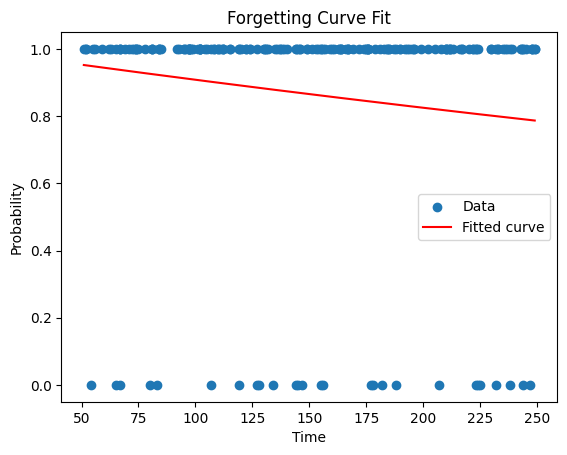

Fitted s: 45.51, decay: -0.04, Log loss: 0.3950


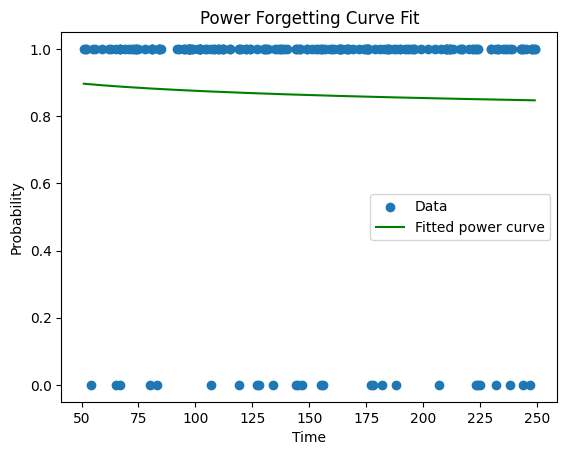

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt


def exp_forgetting_curve(t, s):
    return np.power(0.9, t / s).clip(0.0001, 0.9999)


def power_forgetting_curve(t, s, decay):
    factor = 0.9 ** (1 / decay) - 1
    return ((1 + factor * t / s) ** decay).clip(0.0001, 0.9999)

def fit_exp_forgetting_curve(t, y):
    def loss(stability):
        y_pred = exp_forgetting_curve(t, stability)
        loss = sum(
            -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        )
        return loss

    res = minimize(loss, x0=1, bounds=[(0.01, 36500)])
    return res.x[0]

def fit_power_forgetting_curve(t, y):
    def loss(params):
        stability, decay = params
        y_pred = power_forgetting_curve(t, stability, decay)
        loss = sum(
            -(y * np.log(y_pred) + (1 - y) * np.log(1 - y_pred))
        )
        return loss

    res = minimize(loss, x0=[1, -1], bounds=[(0.01, 36500), (-1, -0.01)])
    return res.x[0], res.x[1]

s = 100
t_sample = np.random.randint(50, 250, 200)
t_sample.sort()
p = exp_forgetting_curve(t_sample, s)
y_sample = np.random.binomial(1, p)

# Fit the exponential forgetting curve
s_fit = fit_exp_forgetting_curve(t_sample, y_sample)
# Calculate the fitted values
p_fit = exp_forgetting_curve(t_sample, s_fit)
# Calculate the log loss
loss = log_loss(y_sample, p_fit)
print(f"Fitted s: {s_fit:.2f}, Log loss: {loss:.4f}")
# Plot the results
plt.scatter(t_sample, y_sample, label="Data")
plt.plot(t_sample, p_fit, color="red", label="Fitted curve")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Forgetting Curve Fit")
plt.legend()
plt.show()

# Fit the power forgetting curve
s_fit_power, decay_fit = fit_power_forgetting_curve(t_sample, y_sample)
# Calculate the fitted values
p_fit_power = power_forgetting_curve(t_sample, s_fit_power, decay_fit)
# Calculate the log loss
loss_power = log_loss(y_sample, p_fit_power)
print(f"Fitted s: {s_fit_power:.2f}, decay: {decay_fit:.2f}, Log loss: {loss_power:.4f}")
# Plot the results
plt.scatter(t_sample, y_sample, label="Data")
plt.plot(t_sample, p_fit_power, color="green", label="Fitted power curve")
plt.xlabel("Time")
plt.ylabel("Probability")
plt.title("Power Forgetting Curve Fit")
plt.legend()
plt.show()